# Theme

Paper: Dynamic Contextualized Word Embeddings

Link: https://aclanthology.org/2021.acl-long.542/



# Plan of the project

Основная цель: адаптировать код авторов статьи для работы с русским языком 

1. Подготовить корпус

Цель: найти корпус текстов с временными и социальными метками

Каждый элемент датасета должен содержать:

* текст
* временную метку
* метку для социального узла

2. Построить граф на основе социальных меток
3. 

# Imports

In [2]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 17.4 MB/s eta 0:00:0000:01


In [251]:
!pip install node2vec

In [252]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html


In [264]:
import argparse
import logging
import os
import pickle
import random
import re
import sys
import time
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric
from IPython.display import HTML
from nltk.corpus import stopwords
from node2vec import Node2Vec
from pyvis.network import Network
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, GCNConv
from transformers import BertForMaskedLM, BertModel, BertTokenizer

In [253]:
print(torch.__version__)
print(torch_geometric.__version__)


2.5.1+cu121
2.6.1


# Corpus preparation

Я взяла корпус открыток Пишу тебе, потому что работаю с ним же в рамках ВКР. У данного корпуса есть текст, есть дата создания и есть разные метки для социальных узлов. 

НО этот корпус довольно разрознен, он неравномерен, одни и те же метки могут записываться по-разному. Поэтому при обработке большая часть данных была отброшена или потеряна

In [3]:
df = pd.read_excel("/kaggle/input/copy-pishu-tebe-corpus/_ _ .xlsx")
df.head()

,Номер открытки,Лицевая сторона - ссылка,Оборотная сторона - ссылка,Язык текста открытки,Текст открытки,Перевод текста открытки (если на иностранном языке),Вид орфографии,"Дата написания текста (если автор указал явно, не штемпели)",Адрес отправителя,Имя отправителя,...,Населенный пункт (откуда),Страна (куда),Населенный пункт (куда),Тег_1,Тег_2,Тег_3,Тег_4,Тег_5,Тег_6,Тег_7
0,321582,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,русский,Бердичов 11-го Ноября 1883 Господину [нрзб] Пр...,NaN,"Дореволюционная (ъ,ѣ и т.д.)",11.11.1883,[отсутствует],[отсутствует],...,"Киевская губерния, Бердичесвкий уезд, г. Бердичев",Российская Империя,г. Москва,Просьба,Деловая переписка,NaN,NaN,NaN,NaN,NaN
1,318036,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,русский,Вильно 17го августа 1886. Милостивый Государь!...,NaN,"Дореволюционная (ъ,ѣ и т.д.)",17.08.1886,[отсутствует],Розенберг,...,"Виленская губерния, Виленский уезд, г. Вильно",Российская Империя,"Курлянская губерния, Виндавский уезд, г. Аненгюте",Шлю привет,Деловая переписка,Просьба,Совет,NaN,NaN,NaN
2,328571,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,русский,Мариинский театр Составлено на {11 Сент}. Ложа...,NaN,"Дореволюционная (ъ,ѣ и т.д.)",[отсутствует],[отсутствует],[отсутствует],...,[отсутствует],Российская Империя,г. Санкт-Петербург,Открытка-приглашение,NaN,NaN,NaN,NaN,NaN,NaN
3,329560,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,русский,{<подпись> X11/20} Милостивый Государь! Г-ну Х...,NaN,"Дореволюционная (ъ,ѣ и т.д.)",20.12.xxxx,[отсутствует],[отсутствует],...,[отсутствует],Российская Империя,"Воронежская губерния, Бобровский уезд, деревня...",Деловая переписка,Деньги,Житейское,Деловая переписка,NaN,NaN,NaN
4,224205,https://storage.yandexcloud.net/postcards-resi...,https://storage.yandexcloud.net/postcards-resi...,русский,Прошу оставить мне два места на 6 или 5 скамей...,NaN,"Дореволюционная (ъ,ѣ и т.д.)",[отсутствует],[отсутствует],Нелюбов,...,[отсутствует],Российская Империя,г. Санкт-Петербург,Просьба,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_filtered = df[df["Язык текста открытки"] == "русский"][[
    "Текст открытки",
    "Дата открытки (нормализованная)",
    "Населенный пункт (откуда)",
    "Населенный пункт (куда)",
    "Тег_1"]]
df_filtered = df_filtered.dropna(subset=["Дата открытки (нормализованная)"])
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40058 entries, 0 to 46726
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Текст открытки                   40058 non-null  object
 1   Дата открытки (нормализованная)  40058 non-null  object
 2   Населенный пункт (откуда)        40058 non-null  object
 3   Населенный пункт (куда)          40058 non-null  object
 4   Тег_1                            39780 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


Изначально я хотела использовать еще и тематический тэг, но позже остановилась лишь на городах отправления и прибытия

In [5]:
def process_location(location):
    # Разделяем строку по первой запятой и берем первую часть
    if "," in location:
        location = location.split(",")[0]

    # Удаляем слово "губерния" (с учетом пробелов)
    location = location.replace("губерния", "").strip()

    # Если есть "г.", оставляем только часть после "г."
    if "г." in location:
        location = location.split("г.")[-1].strip()

    location = location.replace(" ", "-")

    if location == "[отсутствует]":
        location = "неизвестно"

    return location

In [6]:
def process_tag(tag):

    if pd.isna(tag):
        return "без_тега"

    tag = str(tag)


    tag = tag.replace(" ", "-")

    if tag == "":
        return "без-тега"

    return tag

In [7]:
df_filtered["город_откуда"] = df_filtered["Населенный пункт (откуда)"].apply(process_location)
df_filtered["город_куда"] = df_filtered["Населенный пункт (куда)"].apply(process_location)
df_filtered["Тег_1"] = df_filtered["Тег_1"].apply(process_tag)


Можно было также использовать страны, но это были бы менее разнообразные узлы, поэтому я остановилась на городах 

In [8]:
replace_dict = {
    "Российская-Советская-Федеративная-Социалистическая-Республика": "РСФСР",
    "Украинская-Советская-Социалистическая-Республика": "УССР",
    "Украинская-ССР": "УССР",
}

# Заменяем значения в столбцах
df_filtered["город_откуда"] = df_filtered["город_откуда"].replace(replace_dict)
df_filtered["город_куда"] = df_filtered["город_куда"].replace(replace_dict)

In [9]:
df_filtered.head()

,Текст открытки,Дата открытки (нормализованная),Населенный пункт (откуда),Населенный пункт (куда),Тег_1,город_откуда,город_куда
0,Бердичов 11-го Ноября 1883 Господину [нрзб] Пр...,11.11.1883,"Киевская губерния, Бердичесвкий уезд, г. Бердичев",г. Москва,Просьба,Киевская,Москва
1,Вильно 17го августа 1886. Милостивый Государь!...,17.08.1886,"Виленская губерния, Виленский уезд, г. Вильно","Курлянская губерния, Виндавский уезд, г. Аненгюте",Шлю-привет,Виленская,Курлянская
2,Мариинский театр Составлено на {11 Сент}. Ложа...,07.09.1890,[отсутствует],г. Санкт-Петербург,Открытка-приглашение,неизвестно,Санкт-Петербург
3,{<подпись> X11/20} Милостивый Государь! Г-ну Х...,20.12.1890,[отсутствует],"Воронежская губерния, Бобровский уезд, деревня...",Деловая-переписка,неизвестно,Воронежская
4,Прошу оставить мне два места на 6 или 5 скамей...,07.02.1891,[отсутствует],г. Санкт-Петербург,Просьба,неизвестно,Санкт-Петербург


Социальный узелл в итоге будет состоять из городов, без тэгов

In [10]:
df_filtered["social_id"] = (
    df_filtered["город_откуда"].astype(str) + "_"
    + df_filtered["город_куда"].astype(str)
    # + df_filtered["Тег_1"].fillna("без-тега").astype(str)
)
df_filtered.head()

,Текст открытки,Дата открытки (нормализованная),Населенный пункт (откуда),Населенный пункт (куда),Тег_1,город_откуда,город_куда,social_id
0,Бердичов 11-го Ноября 1883 Господину [нрзб] Пр...,11.11.1883,"Киевская губерния, Бердичесвкий уезд, г. Бердичев",г. Москва,Просьба,Киевская,Москва,Киевская_Москва
1,Вильно 17го августа 1886. Милостивый Государь!...,17.08.1886,"Виленская губерния, Виленский уезд, г. Вильно","Курлянская губерния, Виндавский уезд, г. Аненгюте",Шлю-привет,Виленская,Курлянская,Виленская_Курлянская
2,Мариинский театр Составлено на {11 Сент}. Ложа...,07.09.1890,[отсутствует],г. Санкт-Петербург,Открытка-приглашение,неизвестно,Санкт-Петербург,неизвестно_Санкт-Петербург
3,{<подпись> X11/20} Милостивый Государь! Г-ну Х...,20.12.1890,[отсутствует],"Воронежская губерния, Бобровский уезд, деревня...",Деловая-переписка,неизвестно,Воронежская,неизвестно_Воронежская
4,Прошу оставить мне два места на 6 или 5 скамей...,07.02.1891,[отсутствует],г. Санкт-Петербург,Просьба,неизвестно,Санкт-Петербург,неизвестно_Санкт-Петербург


In [11]:
print(df_filtered["город_откуда"].nunique())
print(df_filtered["город_куда"].nunique())
print(df_filtered["social_id"].nunique())

2049
1739
8231


У меня слишком много уникальных данных, поэтому я хочу оставить лишь те датапоинты, которые содержать больше 100 текстов. Если будет много уникальных данных, модель не обучится 

In [12]:
# Группировка для городов "откуда"
city_from_counts = df_filtered["город_откуда"].value_counts()
df_filtered["город_откуда_group"] = df_filtered["город_откуда"].apply(
    lambda x: x if city_from_counts[x] >= 100 else "ДругиеОткуда"
)

# Группировка для городов "куда"
city_to_counts = df_filtered["город_куда"].value_counts()
df_filtered["город_куда_group"] = df_filtered["город_куда"].apply(
    lambda x: x if city_to_counts[x] >= 100 else "ДругиеКуда"
)

# Создаем новый social_id
df_filtered["social_id"] = df_filtered["город_откуда_group"] + "_" + df_filtered["город_куда_group"]

In [13]:
print(df_filtered["social_id"].nunique())

732


In [14]:
print(df_filtered["social_id"].value_counts().describe())

count     732.000000
mean       54.724044
std       414.170069
min         1.000000
25%         2.000000
50%         5.000000
75%        15.000000
max      7762.000000
Name: count, dtype: float64


Слишком большая разница между минимальным и максимальным значениями, придется еще обрезать данные 

In [15]:
social_id_counts = df_filtered["social_id"].value_counts()
df_filtered = df_filtered[df_filtered["social_id"].isin(social_id_counts[social_id_counts >= 100].index)]
print(df_filtered["social_id"].value_counts().describe())

count      42.000000
mean      760.809524
std      1584.616492
min       110.000000
25%       154.750000
50%       283.000000
75%       464.250000
max      7762.000000
Name: count, dtype: float64


# Создание графа

Далее создаем граф на основе городов отправления и прибытия 

In [19]:


# Создаем граф
G = nx.Graph()

# Добавляем ребра на основе частоты связей
for _, row in df_filtered.iterrows():
    source = row["город_откуда_group"]
    target = row["город_куда_group"]
    if G.has_edge(source, target):
        G[source][target]["weight"] += 1
    else:
        G.add_edge(source, target, weight=1)


Посмотрим на то, как вяглядит мой граф

In [265]:


net = Network(notebook=True, height="750px", width="100%", cdn_resources='remote')

# настраиваю отображение графа
net.force_atlas_2based(
    gravity=-60,  
    central_gravity=0.1, 
    spring_length=150,  
    spring_strength=0.1,  
    damping=1.0  
)

net.from_nx(G)

net.show("граф.html")
HTML(filename="граф.html")


граф.html


красота

In [27]:
# Преобразуем в datetime и извлекаем компоненты
df_filtered["date"] = pd.to_datetime(
    df_filtered["Дата открытки (нормализованная)"], 
    errors='coerce'
)

df_filtered["year"] = df_filtered["date"].dt.year
df_filtered["month"] = df_filtered["date"].dt.month.fillna(1)  # Если месяц неизвестен - ставим январь

# Формируем строку в формате ГГГГ-ММ - этот формат нужен для корректного обучения как в статье
df_filtered["time"] = df_filtered["year"].astype(str) + "-" + df_filtered["month"].astype(str).str.zfill(2)

<ipython-input-27-09e82f30cf08>:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_filtered["date"] = pd.to_datetime(


In [28]:
df_filtered

,Текст открытки,Дата открытки (нормализованная),Населенный пункт (откуда),Населенный пункт (куда),Тег_1,город_откуда,город_куда,social_id,город_откуда_group,город_куда_group,date,year,month,time
1,Вильно 17го августа 1886. Милостивый Государь!...,17.08.1886,"Виленская губерния, Виленский уезд, г. Вильно","Курлянская губерния, Виндавский уезд, г. Аненгюте",Шлю-привет,Виленская,Курлянская,ДругиеОткуда_ДругиеКуда,ДругиеОткуда,ДругиеКуда,1886-08-17,1886.0,8.0,1886.0-8.0
2,Мариинский театр Составлено на {11 Сент}. Ложа...,07.09.1890,[отсутствует],г. Санкт-Петербург,Открытка-приглашение,неизвестно,Санкт-Петербург,неизвестно_Санкт-Петербург,неизвестно,Санкт-Петербург,1890-09-07,1890.0,9.0,1890.0-9.0
3,{<подпись> X11/20} Милостивый Государь! Г-ну Х...,20.12.1890,[отсутствует],"Воронежская губерния, Бобровский уезд, деревня...",Деловая-переписка,неизвестно,Воронежская,неизвестно_ДругиеКуда,неизвестно,ДругиеКуда,1890-12-20,1890.0,12.0,1890.0-12.0
4,Прошу оставить мне два места на 6 или 5 скамей...,07.02.1891,[отсутствует],г. Санкт-Петербург,Просьба,неизвестно,Санкт-Петербург,неизвестно_Санкт-Петербург,неизвестно,Санкт-Петербург,1891-02-07,1891.0,2.0,1891.0-2.0
5,"Очень благодарю Вас Роман Иванович за ответ, и...",23.06.1891,"Великое княжество Финляндское, Выборгская губе...",г. Санкт-Петербург,Житейское,Великое-княжество-Финляндское,Санкт-Петербург,ДругиеОткуда_Санкт-Петербург,ДругиеОткуда,Санкт-Петербург,1891-06-23,1891.0,6.0,1891.0-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46718,Здравствуйте Славная Варя Уже давно не получал...,1914-11-14 00:00:00,[отсутствует],"Томская губерния, г. Каинск",Почему-долго-не-писал?,неизвестно,Томская,неизвестно_ДругиеКуда,неизвестно,ДругиеКуда,1914-11-14,1914.0,11.0,1914.0-11.0
46720,Шлю вам сердечное поздравление с Р.Х. и Новым ...,1916-01-01 00:00:00,[отсутствует],г. Москва,Поздравление-в-тексте,неизвестно,Москва,неизвестно_Москва,неизвестно,Москва,1916-01-01,1916.0,1.0,1916.0-1.0
46721,папульку детка крепко [нрзб] скоро к тебя твоя Н.,1907-04-11 00:00:00,[отсутствует],"Киевская губерния, Киевский уезд, г. Киев",Виды-городов,неизвестно,Киевская,неизвестно_Киевская,неизвестно,Киевская,1907-04-11,1907.0,4.0,1907.0-4.0
46722,"Милая Мария Васильевна, Благодарю Вас за [нрзб...",1916-04-25 00:00:00,[отсутствует],г. Москва,Благодарность-в-тексте,неизвестно,Москва,неизвестно_Москва,неизвестно,Москва,1916-04-25,1916.0,4.0,1916.0-4.0


In [29]:
df_filtered = df_filtered[["Текст открытки", "time", "social_id"]]

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31954 entries, 1 to 46726
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Текст открытки  31954 non-null  object
 1   time            31954 non-null  object
 2   social_id       31954 non-null  object
dtypes: object(3)
memory usage: 998.6+ KB


Переименую колонку в тот вид, который ожидается при обучении

In [33]:
df_filtered.rename(columns={'social_id': 'social_node_id'}, inplace=True)

<ipython-input-33-897701f10d1e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename(columns={'social_id': 'social_node_id'}, inplace=True)


# Преобразование авторского кода

Склонирую репозиторий с кодом из статьи сюда

In [36]:
!git clone https://github.com/valentinhofmann/dcwe.git


Cloning into 'dcwe'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 45 (delta 1), reused 1 (delta 1), pack-reused 41 (from 1)
Receiving objects: 100% (45/45), 18.37 KiB | 4.59 MiB/s, done.
Resolving deltas: 100% (14/14), done.


В начале я планировала обучать непосредственно модель, которая прописана авторами. Однако впослледствии стало ясно, что это невозможно по нескольким причинам:

1. Некоторые настройки устарели
2. Под мои данные нужно менять все основные файлы для обучения

Поэтому в итоге я решила переписать авторский код под себя почти полностью, но я все равно работаю внутри директории авторов для аутентичности и так удобнее

In [37]:
%cd dcwe

/kaggle/working/dcwe


In [38]:
print("Содержимое папки data:", os.listdir("./data"))

Содержимое папки data: ['preprocess_data.py', 'train_vectors.py']


In [40]:
os.makedirs("./data", exist_ok=True)
# сохраняю граф для последующего обучения
nx.write_edgelist(G, "./data/graph.edgelist", data=["weight"])

# Код для подготовки данных

В данном случае я модифицирую авторский код, который находится в preprocess_data.py. Для удобства я записываю его в одну ячейку в виде функции, чтобы не обращаться к файлу

Изнаально я планировала обучать эмбеддинги по годам и месяцам как это делают авторы, однако мне просто не хватило мощности ГПУ. В итоге я работаю только с годами 

In [41]:
#preprocess_data.py for postcards

def main():
    # Загрузка данных
    df = df_filtered.copy()
    
    # Очистка текста с особенностями для открыток 
    def clean_text(text):
        if not isinstance(text, str): 
            return ""
        text = re.sub(r"\{.*?\}", "", text)  # Удаление поврежденных участков
        text = re.sub(r"\[нрзб\]", "", text)  # Удаление неразборчивых пометок
        return text.strip()
    
    df["text"] = df["Текст открытки"].astype(str).apply(clean_text)
    
    df[["year_part", "month_part"]] = df["time"].str.split("-", expand=True)
    df["year"] = pd.to_numeric(df["year_part"].str.replace(".0", ""), errors='coerce').fillna(0).astype(int)
    # df["month"] = pd.to_numeric(df["month_part"].str.replace(".0", ""), errors='coerce').fillna(1).astype(int)
    

    df = df[df["text"].str.split().str.len() >= 3]  
    
    # Подготовка финального датасета
    data = pd.DataFrame({
        "user": df["social_node_id"],
        "text": df["text"],
        "year": df["year"],
        # "month": df["month"],
        # "time": df["year"].astype(str) + "-" + df["month"].astype(str).str.zfill(2)
        "time": df["year"].astype(str)
    }).dropna()
    
    train_dev, test = train_test_split(data, test_size=0.2, random_state=42)
    train, dev = train_test_split(train_dev, test_size=0.125, random_state=42)
    
    train.to_json("./data/postcards_train.jsonl", orient="records", lines=True, force_ascii=False)
    dev.to_json("./data/postcards_dev.jsonl", orient="records", lines=True, force_ascii=False)
    test.to_json("./data/postcards_test.jsonl", orient="records", lines=True, force_ascii=False)
    
    # Построение графа
    edge_set = set()
    for node in data["user"].unique():
        parts = str(node).split("_")
        if len(parts) >= 2:
            source = parts[0]
            target = parts[-1]
            if source != "неизвестно" and target != "неизвестно":
                edge_set.add((source, target))
    
    # Сохранение графа и пользователей
    with open('./data/postcards_edges.p', 'wb') as f:
        pickle.dump(edge_set, f)
    with open('./data/postcards_users.p', 'wb') as f:
        pickle.dump(set(data["user"]), f)

if __name__ == '__main__':
    main()

ОБРАЩАЮ ВНИМАНИЕ 

что я везде оставляю users, хотя никаких пользователей у меня нет, но есть города. Это также для более удобного воспроизведения кода, так как его структура оказалась довольно сложной

В случае авторов пользователи это авторы комментариев на рэддите. У меня это города. Все это в любом случае просто разные социальные метки

In [42]:
print("Содержимое папки data:", os.listdir("./data"))

Содержимое папки data: ['postcards_test.jsonl', 'postcards_dev.jsonl', 'postcards_users.p', 'postcards_edges.p', 'graph.edgelist', 'preprocess_data.py', 'train_vectors.py', 'postcards_train.jsonl']


# Код для обучения векторов на графе

Далее я модифицирую авторский файл train_vectors, который обучает социальные вектора на основе полученного графа. Конкретно этот код обучает Node2Vec — модель для генерации эмбеддингов узлов графа на основе их связей.

In [44]:
#train_vectors.py for postcards
def main(dim=128, walk_length=30, num_walks=20, workers=4):
    # Загрузка данных
    with open('./data/postcards_edges.p', 'rb') as f:
        edge_set = pickle.load(f)
    with open('./data/postcards_users.p', 'rb') as f:
        users = pickle.load(f)
        users = list(set(users))

    print(f"Загружено {len(users)} пользователей и {len(edge_set)} связей")

     # Фильтрация связей для удаления несуществующих пользователей
    filtered_edge_set = [(u, v) for u, v in edge_set if u in users and v in users]

    # Построение графа
    graph = nx.DiGraph()
    graph.add_nodes_from(users)
    graph.add_edges_from(filtered_edge_set)   



    # Проверки
    print(f"Количество пользователей: {len(users)}")
    print(f"Количество узлов в графе: {graph.number_of_nodes()}")
    assert graph.number_of_nodes() == len(users), "Количество узлов в графе не совпадает с количеством пользователей!"
    assert graph.number_of_edges() == len(filtered_edge_set), "Количество ребер не совпадает с количеством связей!"

    # Параметры для исторических данных
    n2v = Node2Vec(
        graph,
        dimensions=dim,
        walk_length=walk_length,
        num_walks=num_walks,
        workers=workers,
        p=0.5,
        q=2.0,
        quiet=True
    )

    # Обучение модели
    print("Обучение node2vec модели...")
    n2v_model = n2v.fit(
        window=5,
        min_count=1,
        batch_words=128,
        seed=42
    )

    # Сохранение векторов
    output_file = f'./data/postcards_vectors_{dim}d.txt'
    n2v_model.wv.save_word2vec_format(output_file, binary=False)
    print(f"Векторы сохранены в {output_file}")

# Запуск с параметрами
main(dim=128, walk_length=30, num_walks=20, workers=4)

  

Загружено 42 пользователей и 29 связей
Количество пользователей: 42
Количество узлов в графе: 42
Обучение node2vec модели...
Векторы сохранены в ./data/postcards_vectors_128d.txt


In [45]:
print("Содержимое папки data:", os.listdir("./data"))

Содержимое папки data: ['postcards_test.jsonl', 'postcards_dev.jsonl', 'postcards_vectors_128d.txt', 'postcards_users.p', 'postcards_edges.p', 'graph.edgelist', 'preprocess_data.py', 'train_vectors.py', 'postcards_train.jsonl']


# Код для преобразования Dataset

Далее я модифицирую файл data_helpers. Вообще, я создала свой класс наследник от стандартного Dataset торча, потому что авторский, опять же, мне не подходил. Я решила использовать берт модель, как и авторы, но для русского языка. Авторы работают с месяцами и днями, а мне нужны только года, поэтому некоторые места закомментированы во избежание ошибок 

In [49]:
#data_helpers for postcards 

try:
    stops = set(stopwords.words('russian'))
except:
    import nltk
    nltk.download('stopwords')
    stops = set(stopwords.words('russian'))


class MLMDataset(Dataset):
    """Dataset class for masked language modeling."""

    def __init__(self, name, split, social_dim, data_dir):

        self.tok = BertTokenizer.from_pretrained('bert-base-uncased')

        data = pd.read_csv('{}/{}_{}.csv'.format(data_dir, name, split), parse_dates=['time'])

        data.dropna(inplace=True)
        data.time = pd.to_datetime(data.time)
        data.reset_index(inplace=True, drop=True)

        self.users = list(data.user)
        self.years = list(data.year)
        self.months = list(data.month)
        # self.days = list(data.day)

        if name == 'reddit':
            self.times = list(data.month.apply(convert_times, name=name))
        elif name == 'arxiv' or name == 'ciao' or name == 'yelp':
            self.times = list(data.year.apply(convert_times, name=name))
        self.n_times = len(set(self.times))

        vocab = defaultdict(Counter)
        for text, time in zip(data.text, self.times):
            vocab[time].update(text.strip().split())
        for time in vocab:
            total = sum(vocab[time].values())
            vocab[time] = {w: count / total for w, count in vocab[time].items()}
        w_counts = dict()
        for time in vocab:
            for w in vocab[time]:
                w_counts[w] = w_counts.get(w, 0) + vocab[time][w]
        w_top = sorted(w_counts.keys(), key=lambda x: w_counts[x], reverse=True)[:100000]
        filter_list = [w for w in w_top if w not in stops and w in self.tok.vocab and w.isalpha()]
        self.filter_tensor = torch.tensor([t for t in self.tok.encode(filter_list) if t >= 2100])

        self.reviews = list(data.text.apply(self.tok.encode, add_special_tokens=True))
        self.reviews = truncate(self.reviews)

        self.user2id, self.graph_data = load_external_data(name, social_dim, data_dir)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):

        user = self.users[idx]
        year = self.years[idx]
        # month = self.months[idx]
        # day = self.days[idx]
        time = self.times[idx]
        review = self.reviews[idx]

        return user, time, year, month, day, review


class PostcardsMLMDataset(Dataset):
    """Дтасет для исторических открыток"""
    
    def __init__(self, name, split, social_dim, data_dir):
        self.tok = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
        self.df = pd.read_json(f'{data_dir}/{split}.jsonl', lines=True)
        
        # Очистка и проверка данных
        self.df['text'] = self.df['text'].apply(self._clean_text)
        self.df = self.df[self.df['text'].str.len() > 0]  # Удаляем пустые тексты
        
        # Обработка временных меток
        self._process_temporal_data()
        
        # Построение словаря
        self._build_vocabulary()
        
        # Загрузка графа
        self.user2id, self.graph_data = self._load_social_graph(name, social_dim, data_dir)
    
    def _clean_text(self, text):
        """Очистка текста с обработкой особых случаев"""
        if not isinstance(text, str):
            return ""
        text = re.sub(r"\{.*?\}|\[нрзб\]", "", text)
        return text.strip()
    
    def _process_temporal_data(self):
        """Обработка временных меток с проверкой"""
        self.users = self.df['user'].astype(str).tolist()
        
        self.years = self.df['year'].tolist()
        # self.months = self.df['month'].tolist()
        # # self.days = self.df['day'].tolist()

        # time_indices = [
        # (year - 1800) * 12 + (month - 1)  # Пример: 1905-03 → (1905-1800)*12 + (3-1) = 105*12 + 2 = 1262
        # for year, month in zip(self.df['year'], self.df['month'])
        # ]
        
        # self.times = time_indices
        # self.n_times = max(time_indices) + 1 

        self.times = [year - 1800 for year in self.years]  # или просто self.years
        self.n_times = max(self.times) + 1
        
    def _build_vocabulary(self):
        """Построение словаря с защитой от пустых значений"""
        vocab = defaultdict(Counter)
        
        for text, time in zip(self.df['text'], self.times):
            words = re.findall(r'\w+', text.lower())
            vocab[time].update(words)
        
        all_words = set()
        for time in vocab:
            all_words.update(vocab[time].keys())
        
        # Фильтрация и сортировка слов по частоте
        filtered_words = [w for w in all_words if w and w in self.tok.vocab]
        filtered_words.sort(key=lambda x: -sum(vocab[t][x] for t in vocab))
        filtered_words = filtered_words[:50000]  # Ограничиваем размер словаря для экономии ресурсов
        
        if filtered_words:
            encoded = []
            for w in filtered_words:
                try:
                    tokens = self.tok.encode(w, add_special_tokens=False)
                    encoded.extend(tokens)
                except:
                    continue
            self.filter_tensor = torch.tensor(list(set(encoded))) if encoded else torch.tensor([])
        else:
            self.filter_tensor = torch.tensor([])
        
        self.reviews = []
        for text in self.df['text']:
            try:
                encoded = self.tok.encode(text, add_special_tokens=True)
                if len(encoded) > 512:
                    half = 256
                    encoded = encoded[:half] + encoded[-half:]
                self.reviews.append(encoded)
            except:
                self.reviews.append([self.tok.pad_token_id])

    def _load_social_graph(self, name, social_dim, data_dir):
        """Загрузка графа с обработкой ошибок"""
        try:
            with open(f'{data_dir}/{name}_edges.p', 'rb') as f:
                edge_set = pickle.load(f)
            
            with open(f'{data_dir}/{name}_users.p', 'rb') as f:
                users = pickle.load(f)
        except Exception as e:
            print(f"Error loading graph data: {e}")
            # Создаем пустой граф если файлы не найдены
            users = list(set(self.users))
            edge_set = set()
    
        graph = nx.DiGraph()
        graph.add_nodes_from(users)
        graph.add_edges_from(edge_set)
        
        # Создаем случайные эмбеддинги если нет файла векторов
        vector_matrix = np.random.normal(size=(len(users), social_dim))
        
        try:
            vector_file = f'{data_dir}/{name}_vectors_{social_dim}.txt'
            if os.path.exists(vector_file):
                vectors = {}
                with open(vector_file, 'r', encoding='utf-8') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) > 1:
                            vectors[parts[0]] = np.array(parts[1:], dtype=float)
                
                for i, user in enumerate(users):
                    if user in vectors:
                        vector_matrix[i] = vectors[user]
        except Exception as e:
            print(f"Error loading vectors: {e}")
        
        x = torch.tensor(vector_matrix, dtype=torch.float)
        
        # Исправление для новых версий NetworkX,тк авторская устарела
        a = nx.adjacency_matrix(graph, nodelist=users)
        if hasattr(a, 'tocoo'):  # Для совместимости с разными версиями
            a = a.tocoo()
            edge_index = torch.tensor(np.stack((a.row, a.col)), dtype=torch.long)
        else:
            # Альтернативный способ для новых версий
            edge_index = torch.tensor(np.array(list(graph.edges())).T, dtype=torch.long)
        
        return {u: i for i, u in enumerate(users)}, Data(x=x, edge_index=edge_index)
    
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, idx):
        return (
            self.users[idx],
            self.times[idx],
            self.years[idx],
            # self.months[idx],
            # self.days[idx],
            self.reviews[idx]
        )

def truncate(reviews):
    """Усечение длинных последовательностей"""
    truncated = []
    for r in reviews:
        if len(r) > 512:
            r = r[:256] + r[-256:]
        truncated.append(r)
    return truncated
   

class SADataset(Dataset):
    """Dataset class for sentiment analysis."""

    def __init__(self, name, split, social_dim, data_dir):

        # self.tok = BertTokenizer.from_pretrained('bert-base-uncased')
        self.tok = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

        data = pd.read_csv('{}/{}_{}.csv'.format(data_dir, name, split), parse_dates=['time'])

        data.dropna(inplace=True)
        data.time = pd.to_datetime(data.time)
        data.reset_index(inplace=True, drop=True)

        self.labels = list(data.label)
        self.users = list(data.user)
        self.years = list(data.year)
        self.months = list(data.month)
        # self.days = list(data.day)

        self.times = list(data.year.apply(convert_times, name=name))
        self.n_times = len(set(self.times))

        vocab = defaultdict(Counter)
        for text, time in zip(data.text, self.times):
            vocab[time].update(text.strip().split())
        for time in vocab:
            total = sum(vocab[time].values())
            vocab[time] = {w: count / total for w, count in vocab[time].items()}
        w_counts = dict()
        for time in vocab:
            for w in vocab[time]:
                w_counts[w] = w_counts.get(w, 0) + vocab[time][w]
        w_top = sorted(w_counts.keys(), key=lambda x: w_counts[x], reverse=True)[:100000]
        filter_list = [w for w in w_top if w not in stops and w in self.tok.vocab and w.isalpha()]
        self.filter_tensor = torch.tensor([t for t in self.tok.encode(filter_list) if t >= 2100])

        self.reviews = list(data.text.apply(self.tok.encode, add_special_tokens=True))
        self.reviews = truncate(self.reviews)

        self.user2id, self.graph_data = load_external_data(name, social_dim, data_dir)

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):

        label = self.labels[idx]
        user = self.users[idx]
        year = self.years[idx]
        # month = self.months[idx]
        # day = self.days[idx]
        time = self.times[idx]
        review = self.reviews[idx]

        return label, user, time, year, month, day, review


class MLMCollator:
    """Collator class for masked language modeling."""

    def __init__(self, user2id, tok, mlm_p=0.15):

        self.user2id = user2id
        self.tok = tok
        self.mlm_p = mlm_p

    def __call__(self, batch):

        batch_size = len(batch)

        users = torch.tensor([self.user2id[u] for u, _, _, _ in batch]).long()
        times = torch.tensor([t for _, t, _, _ in batch]).long()
        years = torch.tensor([y for _, _, y, _ in batch]).long()
        # months = torch.tensor([m for _, _, _, m, _ in batch]).long()
        # days = torch.tensor([d for _, _, _, _, d, _ in batch]).long()
        reviews = [r for _, _, _, r in batch]

        max_len = max(len(r) for r in reviews)
        reviews_pad = torch.zeros((batch_size, max_len)).long()
        masks_pad = torch.zeros((batch_size, max_len)).long()
        segs_pad = torch.zeros((batch_size, max_len)).long()

        for i, r in enumerate(reviews):
            reviews_pad[i, :len(r)] = torch.tensor(r)
            masks_pad[i, :len(r)] = 1

        labels = reviews_pad.clone()
        p_matrix = torch.full(labels.shape, self.mlm_p)

        special_mask = [self.tok.get_special_tokens_mask(l, already_has_special_tokens=True) for l in labels.tolist()]
        p_matrix.masked_fill_(torch.tensor(special_mask, dtype=torch.bool), value=0.0)
        padding_mask = labels.eq(self.tok.pad_token_id)
        p_matrix.masked_fill_(padding_mask, value=0.0)
        masked_indices = torch.bernoulli(p_matrix).bool()
        labels[~masked_indices] = -100

        indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
        reviews_pad[indices_replaced] = self.tok.convert_tokens_to_ids(self.tok.mask_token)

        indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
        random_words = torch.randint(len(self.tok), labels.shape, dtype=torch.long)
        reviews_pad[indices_random] = random_words[indices_random]

        return labels, users, times, years, reviews_pad, masks_pad, segs_pad


class SACollator:
    """Collator class for sentiment analysis."""

    def __init__(self, user2id):

        self.user2id = user2id

    def __call__(self, batch):

        batch_size = len(batch)

        labels = torch.tensor([l for l, _, _, _, _, _, _ in batch]).float()
        users = torch.tensor([self.user2id[u] for _, u, _, _, _, _, _ in batch]).long()
        times = torch.tensor([t for _, _, t, _, _, _, _ in batch]).long()
        years = torch.tensor([y for _, _, _, y, _, _, _ in batch]).long()
        months = torch.tensor([m for _, _, _, _, m, _, _ in batch]).long()
        days = torch.tensor([d for _, _, _, _, _, d, _ in batch]).long()
        reviews = [r for _, _, _, _, _, _, r in batch]

        max_len = max(len(r) for r in reviews)
        reviews_pad = torch.zeros((batch_size, max_len)).long()
        masks_pad = torch.zeros((batch_size, max_len)).long()
        segs_pad = torch.zeros((batch_size, max_len)).long()

        for i, r in enumerate(reviews):
            reviews_pad[i, :len(r)] = torch.tensor(r)
            masks_pad[i, :len(r)] = 1

        return labels, users, times, years, months, days, reviews_pad, masks_pad, segs_pad


def convert_times(time, name):

    if name == 'postcards':
        return (time - 1800) // 10  # Десятилетия с 1800 года

    if name == 'arxiv':
        return time - 2001

    elif name == 'ciao':
        return time - 2000

    elif name == 'yelp':
        return time - 2010

    elif name == 'reddit':
        return time - 9


def truncate(reviews):

    truncated = list()

    for r in reviews:
        if len(r) > 512:
            r = r[:256] + r[-256:]
        truncated.append(r)

    return truncated


def load_external_data(name, social_dim, data_dir):
    """Function to load and preprocess graph data and node2vec input embeddings."""

    if name == 'postcards':
        return load_postcards_external_data(name, social_dim, data_dir)

    with open('{}/{}_edges.p'.format(data_dir, name), 'rb') as f:
        edge_set = pickle.load(f)
        if name == 'reddit' or name == 'arxiv':
            edge_set = set(e[:2] for e in edge_set if e[2] > 0.01)

    with open('{}/{}_users.p'.format(data_dir, name), 'rb') as f:
        users = pickle.load(f)

    if name == 'arxiv' or name == 'reddit':
        graph = nx.Graph()
    else:
        graph = nx.DiGraph()

    graph.add_nodes_from(users)
    graph.add_edges_from(edge_set)

    assert graph.number_of_nodes() == len(users)
    assert graph.number_of_edges() == len(edge_set)

    user2id = {u: i for i, u in enumerate(users)}

    vectors = dict()

    with open('{}/{}_vectors_{}.txt'.format(data_dir, name, social_dim), 'r') as f:

        for i, l in enumerate(f):

            if i == 0:
                continue

            if l.strip() == '':
                continue

            if name == 'ciao':
                vectors[int(l.strip().split()[0])] = np.array(l.strip().split()[1:], dtype=float)
            elif name == 'arxiv' or name == 'reddit' or name == 'yelp':
                vectors[str(l.strip().split()[0])] = np.array(l.strip().split()[1:], dtype=float)

    vector_matrix = np.zeros((len(users), social_dim))

    for i, n in enumerate(users):
        vector_matrix[i, :] = vectors[n]

    x = torch.tensor(vector_matrix, dtype=torch.float)

    a = nx.adjacency_matrix(graph, nodelist=users)
    edge_index = torch.tensor(np.stack((a.tocoo().row, a.tocoo().col)).astype(np.int32), dtype=torch.long)

    return user2id, Data(edge_index=edge_index, x=x)


def load_postcards_external_data(name, social_dim, data_dir):
    """Адаптированная загрузка графа для открыток"""
    with open(f'{data_dir}/{name}_edges.p', 'rb') as f:
        edge_set = pickle.load(f)
    
    with open(f'{data_dir}/{name}_users.p', 'rb') as f:
        users = pickle.load(f)
    
    # Ориентированный граф для исторической переписки
    graph = nx.DiGraph()
    graph.add_nodes_from(users)
    graph.add_edges_from(edge_set)
    
    # Загрузка векторов с обработкой кириллицы
    vectors = {}
    with open(f'{data_dir}/{name}_vectors_{social_dim}.txt', 'r', encoding='utf-8') as f:
        next(f)  # Пропуск заголовка
        for line in f:
            parts = line.strip().split()
            if len(parts) > 1:
                vectors[parts[0]] = np.array(parts[1:], dtype=float)
    
    # Создание матрицы признаков
    vector_matrix = np.zeros((len(users), social_dim))
    for i, user in enumerate(users):
        vector_matrix[i] = vectors.get(user, np.random.normal(size=social_dim))
    
    # Подготовка данных для PyG
    x = torch.tensor(vector_matrix, dtype=torch.float)
    a = nx.adjacency_matrix(graph, nodelist=users)
    edge_index = torch.tensor(np.stack((a.row, a.col)), dtype=torch.long)
    
    return {u: i for i, u in enumerate(users)}, Data(x=x, edge_index=edge_index)


def get_best(file, metric):

    try:
        results = list()
        with open(file, 'r') as f:
            for l in f:
                if l.strip() == '':
                    continue
                results.append(tuple([float(v) for v in l.strip().split()]))
        if metric == 'perplexity':
            return min(results)
        elif metric == 'f1':
            return max(results)

    except FileNotFoundError:
        return None


def isin(ar1, ar2):
    return (ar1[..., None] == ar2).any(-1)

sys.modules['data_helpers'] = sys.modules[__name__]

Для корректных импортов модулей из этой ячейки я переназначаю модуль. Хотя для кеггля это не так актуально, но я старалась сохранять авторскую структуру 

# Код для подготовки данных MLM

Следующий файл который требует модификации - pickle_data. Этот код подготавливает и сохраняет данные для обучения модели маскированного языка (MLM) в формате pickle

In [50]:
#pickle_data.py for postcards 

from data_helpers import PostcardsMLMDataset  # Импорт оригинального класса

logging.disable(logging.WARNING)


data_dir = "./data"  # Путь к моим данным
social_dim = 128      # Размерность эмбеддингов

for split in ['postcards_train', 'postcards_dev', 'postcards_test']:
    dataset = PostcardsMLMDataset(
        'postcards',
        split=split,
        social_dim=social_dim,
        data_dir=data_dir
    )
    with open(f"{data_dir}/mlm_postcards_{social_dim}_{split}.p", 'wb') as f:
        pickle.dump(dataset, f)

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

In [51]:
%cd /kaggle/working/dcwe

%pwd

/kaggle/working/dcwe


'/kaggle/working/dcwe'

# Объявление модели 

Далее я модифицирую два самых важных для моей работы файла. Во-первых, это models, где я объявляю модель. Опять же я создала свой отдельный класс по образу и подобию для удобства работы в моей ситуации. Остальной код я оставляю без изменений, кроме, конечно, смены БЕРТ

In [60]:
#model.py for postcards

from data_helpers import isin


class MLMModel(nn.Module):
    """"Class to train dynamic contextualized word embeddings with masked language modeling."""

    def __init__(self, n_times=1, social_dim=50, gnn=None, social_only=False, time_only=False):
        """Initialize dynamic contextualized word embeddings model.

        Args:
            n_times: number of time points (only relevant if time is not ablated)
            social_dim: dimensionality of social embeddings
            gnn: type of GNN (currently 'gat' and 'gcn' are possible)
            social_only: use only social information (temporal ablation)
            time_only: use only temporal information (social ablation)
        """

        super(MLMModel, self).__init__()

        # For ablated models
        self.social_only = social_only
        self.time_only = time_only

        # Contextualizing component
        self.bert = BertForMaskedLM.from_pretrained('DeepPavlov/rubert-base-cased')
        self.bert_emb_layer = self.bert.get_input_embeddings()

        # Dynamic component
        if self.social_only:
            self.social_component = SocialComponent(social_dim, gnn)
        elif self.time_only:
            self.offset_components = nn.ModuleList([OffsetComponent() for _ in range(n_times)])
        else:
            self.social_components = nn.ModuleList([SocialComponent(social_dim, gnn) for _ in range(n_times)])

    def forward(self, labels, reviews, masks, segs, users, g_data, times, vocab_filter, embs_only=False):
        """Perform forward pass.

        Args:
            labels: tensor of masked language modeling labels
            reviews: tensor of tokenized reviews
            masks: tensor of attention masks
            segs: tensor of segment indices
            users: tensor of batch user indices
            g_data: graph data object
            times: tensor of batch time points
            vocab_filter: tensor with word types for dynamic component
            embs_only: only compute dynamic type-level embeddings
        """

        # Retrieve BERT input embeddings
        bert_embs = self.bert_emb_layer(reviews)

        # Temporal ablation
        if self.social_only:
            offset_last = None  # No need to compute embeddings at last time point for temporal ablation
            offset_now = torch.cat(
                [self.social_component(bert_embs[i], users[i], g_data) for i, j in enumerate(times)],
                dim=0
            )
            offset_now = offset_now * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)

        # Social ablation
        elif self.time_only:
            offset_last = torch.cat(
                [self.offset_components[j](bert_embs[i]) for i, j in enumerate(F.relu(times - 1))],
                dim=0
            )
            offset_now = torch.cat(
                [self.offset_components[j](bert_embs[i]) for i, j in enumerate(times)],
                dim=0
            )
            offset_last = offset_last * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)
            offset_now = offset_now * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)

        # Full dynamic component
        else:
            offset_last = torch.cat(
                [self.social_components[j](bert_embs[i], users[i], g_data) for i, j in enumerate(F.relu(times - 1))],
                dim=0
            )
            offset_now = torch.cat(
                [self.social_components[j](bert_embs[i], users[i], g_data) for i, j in enumerate(times)],
                dim=0
            )
            offset_last = offset_last * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)
            offset_now = offset_now * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)

        # Compute dynamic type-level embeddings (input to contextualizing component)
        input_embs = bert_embs + offset_now

        # Only compute dynamic type-level embeddings (not fed into contextualizing component)
        if embs_only:
            return bert_embs, input_embs

        # Pass through contextualizing component
        output = self.bert(inputs_embeds=input_embs, attention_mask=masks, token_type_ids=segs, labels=labels)

        return offset_last, offset_now, output[0]

class RussianMLMModel(nn.Module):
    def __init__(self, n_times=1, social_dim=50, gnn=None, social_only=False, time_only=False):
        super().__init__()
        self.n_times = n_times
        self.social_only = social_only
        self.time_only = time_only

        # Русская BERT модель 
        self.bert = BertForMaskedLM.from_pretrained('DeepPavlov/rubert-base-cased')
        self.bert_emb_layer = self.bert.get_input_embeddings()

        if self.social_only:
            self.social_component = SocialComponent(social_dim, gnn)
        elif self.time_only:
            self.offset_components = nn.ModuleList([OffsetComponent() for _ in range(n_times)])
        else:
            self.social_components = nn.ModuleList([SocialComponent(social_dim, gnn) for _ in range(n_times)])

    def forward(self, labels, reviews, masks, segs, users, g_data, times, vocab_filter, embs_only=False):
        # Реализация forward остается такой же, но будет работать с русскими эмбеддингами
        bert_embs = self.bert_emb_layer(reviews)
        

        times = times.clamp(min=0, max=self.n_times-1)
        prev_times = (times - 1).clamp(min=0)
        
        if self.social_only:
            offset_now = torch.cat(
                [self.social_component(bert_embs[i], users[i], g_data) 
                 for i in range(len(times))],
                dim=0
            )
        else:
            offset_last = torch.cat(
                [self.social_components[j.item()](bert_embs[i], users[i], g_data) 
                 for i, j in enumerate(prev_times)],
                dim=0
            )
            offset_now = torch.cat(
                [self.social_components[j.item()](bert_embs[i], users[i], g_data) 
                 for i, j in enumerate(times)],
                dim=0
            )

        # Compute dynamic type-level embeddings (input to contextualizing component)
        input_embs = bert_embs + offset_now

        # Only compute dynamic type-level embeddings (not fed into contextualizing component)
        if embs_only:
            return bert_embs, input_embs

        # Pass through contextualizing component
        output = self.bert(inputs_embeds=input_embs, attention_mask=masks, token_type_ids=segs, labels=labels)

        return offset_last, offset_now, output[0]


class SAModel(nn.Module):
    """"Class to train dynamic contextualized word embeddings for sentiment analysis."""

    def __init__(self, n_times=1, social_dim=50, gnn=None):
        """Initialize dynamic contextualized word embeddings model.

        Args:
            n_times: number of time points
            social_dim: dimensionality of social embeddings
            gnn: type of GNN (currently 'gat' and 'gcn' are possible)
        """

        super(SAModel, self).__init__()

        self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
        self.bert_emb_layer = self.bert.get_input_embeddings()
        self.social_components = nn.ModuleList([SocialComponent(social_dim, gnn) for _ in range(n_times)])
        self.linear_1 = nn.Linear(768, 100)
        self.linear_2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, reviews, masks, segs, users, g_data, times, vocab_filter, embs_only=False):
        """Perform forward pass.

        Args:
            reviews: tensor of tokenized reviews
            masks: tensor of attention masks
            segs: tensor of segment indices
            users: tensor of batch user indices
            g_data: graph data object
            times: tensor of batch time points
            vocab_filter: tensor with word types for dynamic component
            embs_only: only compute dynamic type-level embeddings
        """

        # Retrieve BERT input embeddings
        bert_embs = self.bert_emb_layer(reviews)
        offset_last = torch.cat(
            [self.social_components[j](bert_embs[i], users[i], g_data) for i, j in enumerate(F.relu(times - 1))],
            dim=0
        )
        offset_now = torch.cat(
            [self.social_components[j](bert_embs[i], users[i], g_data) for i, j in enumerate(times)],
            dim=0
        )
        offset_last = offset_last * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)
        offset_now = offset_now * isin(reviews, vocab_filter).float().unsqueeze(-1).expand(-1, -1, 768)

        # Compute dynamic type-level embeddings (input to contextualizing component)
        input_embs = bert_embs + offset_now

        # Only compute dynamic type-level embeddings (not fed into contextualizing component)
        if embs_only:
            return bert_embs, input_embs

        # Pass through contextualizing component
        output_bert = self.dropout(self.bert(inputs_embeds=input_embs, attention_mask=masks, token_type_ids=segs)[1])
        h = self.dropout(torch.tanh(self.linear_1(output_bert)))
        output = torch.sigmoid(self.linear_2(h)).squeeze(-1)

        return offset_last, offset_now, output


class SocialComponent(nn.Module):
    """"Class implementing the social part of the dynamic component."""

    def __init__(self, social_dim=50, gnn=None):
        super(SocialComponent, self).__init__()
        self.gnn_component = GNNComponent(social_dim, gnn)
        self.linear_1 = nn.Linear(768 + social_dim, 768)
        self.linear_2 = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.2)

    def forward(self, embs, users, graph_data):
        user_output = self.gnn_component(users, graph_data)
        user_output = user_output.unsqueeze(0).expand(embs.size(0), -1)
        h = torch.cat((embs, user_output), dim=-1)
        h = self.dropout(torch.tanh(self.linear_1(h)))
        offset = self.linear_2(h).unsqueeze(0)
        return offset


class GNNComponent(nn.Module):
    """"Class implementing the GNN of the dynamic component."""

    def __init__(self, social_dim=50, gnn=None):
        super(GNNComponent, self).__init__()
        self.social_dim = social_dim
        self.gnn = gnn
        if self.gnn == 'gcn':
            self.conv_1 = GCNConv(self.social_dim, self.social_dim)
            self.conv_2 = GCNConv(self.social_dim, self.social_dim)
        elif self.gnn == 'gat':
            self.conv_1 = GATConv(self.social_dim, self.social_dim, heads=4, dropout=0.6, concat=False)
            self.conv_2 = GATConv(self.social_dim, self.social_dim, heads=4, dropout=0.6, concat=False)
        else:
            self.linear_1 = nn.Linear(self.social_dim, self.social_dim)
            self.linear_2 = nn.Linear(self.social_dim, self.social_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, users, graph_data):
        if self.gnn == 'gcn' or self.gnn == 'gat':
            h = self.dropout(torch.tanh(self.conv_1(graph_data.x, graph_data.edge_index)))
            return self.dropout(torch.tanh(self.conv_2(h, graph_data.edge_index)))[users]
        else:
            h = self.dropout(torch.tanh(self.linear_1(graph_data.x[users])))
            return self.dropout(torch.tanh(self.linear_2(h)))


class OffsetComponent(nn.Module):
    """"Class implementing the dynamic component for social ablation."""

    def __init__(self):
        super(OffsetComponent, self).__init__()
        self.linear_1 = nn.Linear(768, 768)
        self.linear_2 = nn.Linear(768, 768)
        self.dropout = nn.Dropout(0.2)

    def forward(self, embs):
        h = self.dropout(torch.tanh(self.linear_1(embs)))
        offset = self.linear_2(h).unsqueeze(0)
        return offset


class SABert(nn.Module):
    """"Class to train non-dynamic contextualized word embeddings (BERT) for sentiment analysis."""

    def __init__(self):
        super(SABert, self).__init__()
        self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
        self.linear_1 = nn.Linear(768, 100)
        self.linear_2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, reviews, masks, segs):
        output_bert = self.dropout(self.bert(reviews, attention_mask=masks, token_type_ids=segs)[1])
        h = self.dropout(torch.tanh(self.linear_1(output_bert)))
        output = torch.sigmoid(self.linear_2(h)).squeeze(-1)
        return output

# Это абсолютно опционально и нужно для задачи Santiment Analisys которая также может решаться авторами статьи
class RussianSABert(nn.Module):
    def __init__(self):
        super().__init__()
        self.bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')
        self.linear_1 = nn.Linear(768, 100)
        self.linear_2 = nn.Linear(100, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, reviews, masks, segs):
        output_bert = self.dropout(self.bert(reviews, attention_mask=masks, token_type_ids=segs)[1])
        h = self.dropout(torch.tanh(self.linear_1(output_bert)))
        output = torch.sigmoid(self.linear_2(h)).squeeze(-1)
        return output

sys.modules['model'] = sys.modules[__name__]

Для корректного импорта я также перезаписала модуль

# Обучение модели

Наконец, я меняю главный файл - файл обучения. Это было тяжело, очень многое не совпадало и не запускалось, иногда просто не хватало ГПУ. Но в итоге все получилось! Сама суть осталась той же, для формирования гиперпараметров я ориентровалась на статью 

In [61]:
# main_mlm.py for postcards

from data_helpers import PostcardsMLMDataset, MLMCollator
from model import RussianMLMModel  

def main():
    # Настройки для kaggle
    args = argparse.Namespace(
        data_dir='./data',
        results_dir='./results',
        trained_dir='./models',
        data='postcards',
        batch_size=2,
        lr=3e-6,
        n_epochs=5,
        lambda_a=0.1,
        lambda_w=100,
        device=0 if torch.cuda.is_available() else 'cpu',
        social_dim=128,
        gnn='GAT',
        social_only=False,
        time_only=False
    )

    # Создаем директории если их нет
    import os
    os.makedirs(args.results_dir, exist_ok=True)
    os.makedirs(args.trained_dir, exist_ok=True)

    random.seed(123)
    np.random.seed(123)
    torch.manual_seed(123)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(123)

    print('Load datasets...')
    datasets = {}
    for split in ['postcards_train', 'postcards_dev', 'postcards_test']:
        with open(f'{args.data_dir}/mlm_{args.data}_{args.social_dim}_{split}.p', 'rb') as f:
            datasets[split] = pickle.load(f)

    train_dataset, dev_dataset, test_dataset = datasets['postcards_train'], datasets['postcards_dev'], datasets['postcards_test']

    print('Lambda a: {:.0e}'.format(args.lambda_a))
    print('Lambda w: {:.0e}'.format(args.lambda_w))
    print('Social dim: {}'.format(args.social_dim))
    print('Time units: {}'.format(train_dataset.n_times))
    print('Vocab size: {}'.format(len(train_dataset.filter_tensor)))

    collator = MLMCollator(train_dataset.user2id, train_dataset.tok)

    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, 
                            collate_fn=collator, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=args.batch_size, 
                          collate_fn=collator)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, 
                           collate_fn=collator)

    device = torch.device(f'cuda:{args.device}' if torch.cuda.is_available() else 'cpu')

    # Инициализация русскоязычной модели
    model = RussianMLMModel(
        n_times=train_dataset.n_times,
        social_dim=args.social_dim,
        gnn=args.gnn,
        social_only=args.social_only,
        time_only=args.time_only
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    graph_data = train_dataset.graph_data.to(device)
    vocab_filter = train_dataset.filter_tensor.to(device)

    # Проверка лучшего результата
    filename = f'mlm_{args.data}_{args.social_dim}'
    if args.social_only:
        filename += '_s'
    elif args.time_only:
        filename += '_t'

    best_perplexity = None
    results_file = f'{args.results_dir}/{filename}.txt'
    if os.path.exists(results_file):
        with open(results_file, 'r') as f:
            lines = f.readlines()
            if lines:
                best_perplexity = float(lines[-1].split('\t')[0])

    print(f'Best perplexity: {best_perplexity}')

    print('Start training...')
    for epoch in range(1, args.n_epochs + 1):
        model.train()
        epoch_loss = 0
        
        for i, batch in enumerate(train_loader):
            labels, users, times, _, reviews, masks, segs = batch
            
            # Перенос данных на устройство
            inputs = {
                'labels': labels.to(device),
                'reviews': reviews.to(device),
                'masks': masks.to(device),
                'segs': segs.to(device),
                'users': users.to(device),
                'g_data': graph_data,
                'times': times.to(device),
                'vocab_filter': vocab_filter
            }

            optimizer.zero_grad()
            
            # Forward pass через русскую модель
            offset_t0, offset_t1, loss = model(**inputs)
            
            # Регуляризация
            loss += args.lambda_a * torch.norm(offset_t1, dim=-1).pow(2).mean()
            
            if not args.social_only:
                loss += args.lambda_w * torch.norm(offset_t1 - offset_t0, dim=-1).pow(2).mean()
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            if i % 100 == 0:
                print(f'Epoch {epoch}, batch {i}, loss: {loss.item():.4f}')

        # Валидация
        model.eval()
        val_losses = []
        
        with torch.no_grad():
            for batch in dev_loader:
                labels, users, times, _, reviews, masks, segs = batch
                
                inputs = {
                    'labels': labels.to(device),
                    'reviews': reviews.to(device),
                    'masks': masks.to(device),
                    'segs': segs.to(device),
                    'users': users.to(device),
                    'g_data': graph_data,
                    'times': times.to(device),
                    'vocab_filter': vocab_filter
                }
                
                _, _, loss = model(**inputs)
                val_losses.append(loss.item())
        
        perplexity_dev = np.exp(np.mean(val_losses))
        print(f'Epoch {epoch}, dev perplexity: {perplexity_dev:.2f}')
        
        # Сохранение результатов
        with open(results_file, 'a+') as f:
            f.write(f'{perplexity_dev}\t{args.lr}\t{args.lambda_a}\t{args.lambda_w}\n')
        
        # Сохранение лучшей модели (полное сохранение)
        if best_perplexity is None or perplexity_dev < best_perplexity:
            best_perplexity = perplexity_dev
            save_path = f'{args.trained_dir}/{filename}.pt'
            
            # Сохраняем всё необходимое для последующей загрузки
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'perplexity': best_perplexity,
                'social_dim': args.social_dim,
                'gnn_type': args.gnn,
                'n_times': train_dataset.n_times
            }, save_path)
            
            print(f'New best model saved to {save_path} with perplexity: {best_perplexity:.2f}')

if __name__ == '__main__':
    start_time = time.time()
    main()
    print(f'Training completed in {(time.time() - start_time)/60:.1f} minutes')

Load datasets...
Lambda a: 1e-01
Lambda w: 1e+02
Social dim: 128
Time units: 225
Vocab size: 16226


pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Best perplexity: None
Start training...
Epoch 1, batch 0, loss: 382.6248
Epoch 1, batch 100, loss: 439.8842
Epoch 1, batch 200, loss: 403.9220
Epoch 1, batch 300, loss: 425.3893
Epoch 1, batch 400, loss: 432.1132
Epoch 1, batch 500, loss: 389.0048
Epoch 1, batch 600, loss: 419.3941
Epoch 1, batch 700, loss: 395.8902
Epoch 1, batch 800, loss: 367.7677
Epoch 1, batch 900, loss: 403.1626
Epoch 1, batch 1000, loss: 438.1876
Epoch 1, batch 1100, loss: 394.3133
Epoch 1, batch 1200, loss: 372.3605
Epoch 1, batch 1300, loss: 361.9385
Epoch 1, batch 1400, loss: 383.5101
Epoch 1, batch 1500, loss: 370.5039
Epoch 1, batch 1600, loss: 348.4400
Epoch 1, batch 1700, loss: 356.0363
Epoch 1, batch 1800, loss: 296.1913
Epoch 1, batch 1900, loss: 360.4750
Epoch 1, batch 2000, loss: 428.0042
Epoch 1, batch 2100, loss: 356.6989
Epoch 1, batch 2200, loss: 406.5150
Epoch 1, batch 2300, loss: 354.4892
Epoch 1, batch 2400, loss: 396.8777
Epoch 1, batch 2500, loss: 332.4608
Epoch 1, batch 2600, loss: 431.2778


Несмотря на то что Лосс скачет, перплексити уменьшилась до 7, что очень хорошо для БЕРТ (и для моих странных данных). Так что обучением я довольна!

Снижение перплексити почти в половину указывает на успешное обучение модели. Общий тренд снижения потерь подтверждает, что модель обучается корректно. Колебания между батчами нормальны.

# Инференс модели

In [67]:
# Загрузка списка социальных узлов
with open('./data/postcards_users.p', 'rb') as f:
    unique_users = pickle.load(f)

print("Примеры исходных user_id:")
for user in list(unique_users)[:10]:
    print(user)

Примеры исходных user_id:
Санкт-Петербург_ДругиеКуда
неизвестно_Киевская
Ленинград_Ленинград
РСФСР_неизвестно
неизвестно_Москва
ДругиеОткуда_Нижегородская-область
неизвестно_Санкт-Петербургская
ДругиеОткуда_Санкт-Петербургская
ДругиеОткуда_ДругиеКуда
ДругиеОткуда_Ленинград


In [68]:
user_id = user_to_idx.get("неизвестно_Москва", 0)  # 0 как заглушка для неизвестных
user_id

4

In [74]:
from model import RussianMLMModel  

# Загрузка чекпоинта
checkpoint = torch.load('./models/mlm_postcards_128.pt')

# Инициализация модели с параметрами из чекпоинта
model = RussianMLMModel(
    n_times=checkpoint['n_times'],
    social_dim=checkpoint['social_dim'],
    gnn=checkpoint['gnn_type']  # Если используется в __init__
)

# Загрузка весов
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Загрузка токенизатора 
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

<ipython-input-74-32e6ce7e306d>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./models/mlm_postcards_128.pt')


In [75]:
print(f"Загружена модель с параметрами:")
print(f"Эпоха: {checkpoint['epoch']}")
print(f"Лучшая перплексия: {checkpoint['perplexity']}")
print(f"Социальная размерность: {checkpoint['social_dim']}")
print(f"Тип GNN: {checkpoint['gnn_type']}")
print(f"Число временных периодов: {checkpoint['n_times']}")

Загружена модель с параметрами:
Эпоха: 5
Лучшая перплексия: 7.036460447863038
Социальная размерность: 128
Тип GNN: GAT
Число временных периодов: 225


Для корректного доставания эмбеддингов из модели мне нужны данные графа. Для этого я сохраняла ребра и узлы, этот код загружает и подготавливает данные о переписке между городами через открытки, представляя их в виде графа для дальнейшей работы. Каждый город представлен случайным 128-мерным вектором, потому что у меня не получилось собрать граф на основе тех данных, которые я сохраняла. В любом случае изначально меня больше интересовали временные а не социальные метки! Потому что в рамках диплома я разрабатываю алгоритм для темпоральной классификации текстов. Даты мне больше интересны. Но попробовать и с контектстом поработаь тоже здорово 

In [179]:
def load_graph_data():
    
    with open('/kaggle/working/dcwe/data/postcards_users.p', 'rb') as f:
        users = pickle.load(f)
    
    # Разбираем составные идентификаторы
    city_pairs = [user.split('_') for user in users]
    all_cities = set()
    for source, target in city_pairs:
        if source != 'неизвестно':
            all_cities.add(source)
        if target != 'неизвестно':
            all_cities.add(target)
    
    # Создаем mapping городов
    city_to_idx = {city: idx for idx, city in enumerate(all_cities)}
    
    
    with open('/kaggle/working/dcwe/data/postcards_edges.p', 'rb') as f:
        edge_set = pickle.load(f)
    
    # Фильтруем и преобразуем рёбра
    edge_list = []
    for u, v in edge_set:
        if u in city_to_idx and v in city_to_idx:
            edge_list.append([city_to_idx[u], city_to_idx[v]])
    
    # Создаем граф
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    x = torch.randn(len(city_to_idx), 128)  # Признаки городов
    
    
    return Data(x=x, edge_index=edge_index), city_to_idx

# Загрузка данных
graph_data, city_to_idx = load_graph_data()
print(f"Городов: {graph_data.num_nodes}, Рёбер: {graph_data.num_edges}")
print("Пример рёбер:", graph_data.edge_index[:, :5].t().tolist())

Городов: 14, Рёбер: 29
Пример рёбер: [[12, 12], [1, 3], [6, 6], [4, 11], [8, 5]]


Проверяю что граф это объект Data

In [171]:
graph_data.x

tensor([[ 5.7392e-01, -1.4547e+00, -1.8091e+00,  ...,  1.2588e-01,
         -6.2106e-01, -3.0025e-02],
        [ 4.4883e-02,  1.9027e-01, -2.0479e+00,  ...,  3.3839e-01,
          1.1383e+00,  5.6727e-01],
        [-7.2544e-01,  8.0500e-01,  6.5984e-01,  ...,  1.2310e-01,
          1.7494e-01, -1.9425e-04],
        ...,
        [-4.6395e-01,  1.1537e+00, -1.0450e+00,  ...,  6.8376e-01,
         -2.1230e+00,  3.2027e-01],
        [-3.4824e-01,  6.4967e-01, -5.9855e-01,  ...,  2.1396e+00,
          1.6729e+00, -8.3574e-01],
        [-1.1798e-01, -6.1179e-01,  1.0674e+00,  ..., -4.2389e-01,
         -2.2412e+00, -7.3665e-01]])

In [170]:
graph_data.edge_index

tensor([[12,  1,  6,  4,  8,  7, 11,  1,  1,  1,  1,  2,  1,  4,  1,  2, 11,  7,
          8,  6,  1, 11,  4,  1,  1,  2, 11,  1,  2],
        [12,  3,  6, 11,  5,  7, 11,  9,  8,  6, 11, 11, 13,  4,  2,  2,  4, 11,
          8,  5, 10, 12,  5,  4, 12, 12,  5,  5,  5]])

Это функция по получению эмбеддингов слов из обученной модели. Ее делать было также очень сложно, потому что постоянно были несовпадения в размерностях. В итоге вышло так: 

In [188]:
def get_word_embedding(model, word, tokenizer, graph_data, user_idx=0, time_idx=0):
    """
    Получает динамический эмбеддинг слова с учетом социального графа.
    
    Args:
        model: RussianMLMModel
        word: Слово (строка)
        tokenizer: Берт-токенизатор
        graph_data: Граф (Data)
        user_idx: Индекс пользователя (по умолчанию 0)
        time_idx: Временной слой (по умолчанию 0)
    
    Returns:
        Тензор [768] — усреднённый эмбеддинг слова
    """
    # Токенизация
    tokens = tokenizer.tokenize(word)
    if not tokens:
        raise ValueError(f"Слово '{word}' не найдено в словаре BERT")
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Подготовка входных данных
    inputs = {
        "labels": None,
        "reviews": torch.tensor([token_ids]),
        "masks": torch.ones_like(torch.tensor([token_ids])),
        "segs": torch.zeros_like(torch.tensor([token_ids])),
        "users": torch.tensor([user_idx]),
        "g_data": graph_data,
        "times": torch.tensor([time_idx]),
        "vocab_filter": torch.tensor(token_ids),
        "embs_only": True
    }
    
    # Получение эмбеддингов
    with torch.no_grad():
        _, dyn_embs = model(**inputs)
    
    # Усреднение по токенам (для слов типа "кофе" -> ["ко", "##фе"])
    return dyn_embs.mean(dim=1).squeeze()

In [189]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')


# Получаем эмбеддинг слова
word = "ресторан"
embedding = get_word_embedding(model, word, tokenizer, graph_data)

print(f"Эмбеддинг слова '{word}':", embedding.shape)  # [768]
print("Первые 5 значений:", embedding[:5])

Эмбеддинг слова 'ресторан': torch.Size([768])
Первые 5 значений: tensor([-0.0244, -0.0042,  0.0620, -0.0125,  0.0920])


In [246]:
emb1 = get_word_embedding(model, "кофе", tokenizer, graph_data)
emb2 = get_word_embedding(model, "капучино", tokenizer, graph_data)
emb3 = get_word_embedding(model, "велосипед", tokenizer, graph_data)

print("Кофе vs Капучино:", cosine_similarity([emb1], [emb2])[0][0])  
print("Кофе vs Велосипед:", cosine_similarity([emb1], [emb3])[0][0])  

Кофе vs Капучино: 0.7902641
Кофе vs Велосипед: 0.7695873


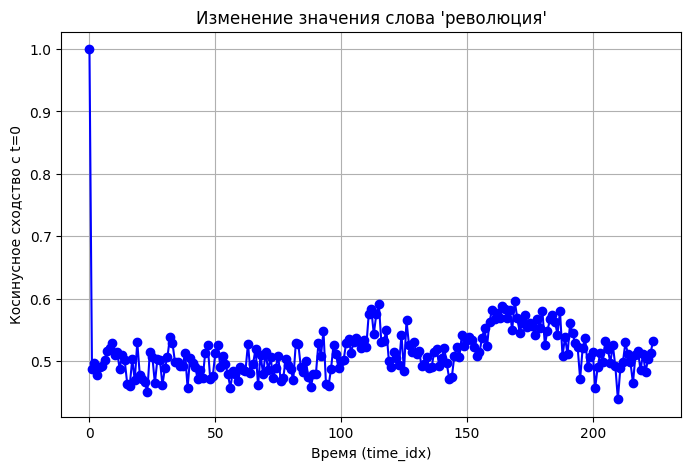

In [250]:
word = "революция"
user_idx = user_to_idx.get("Ленинград_Ленинград", 0)  # Один и тот же социальный узел

# Собираем эмбеддинги по разным временным слоям
time_range = list(range(0, 225))  
embeddings = []

for time_idx in time_range:
    word_emb = get_word_embedding(model, word, tokenizer, graph_data, user_idx, time_idx)
    embeddings.append(word_emb)

# Преобразуем список в тензор
embeddings = torch.stack(embeddings)  
similarities = [1 - cosine(embeddings[0], emb) for emb in embeddings]


plt.figure(figsize=(8, 5))
plt.plot(time_range, similarities, marker="o", linestyle="-", color="b")
plt.xlabel("Время (time_idx)")
plt.ylabel("Косинусное сходство с t=0")
plt.title(f"Изменение значения слова '{word}'")
plt.grid()
plt.show()

Далее я решила посмотреть, как семантическая близость слов меняется со временем

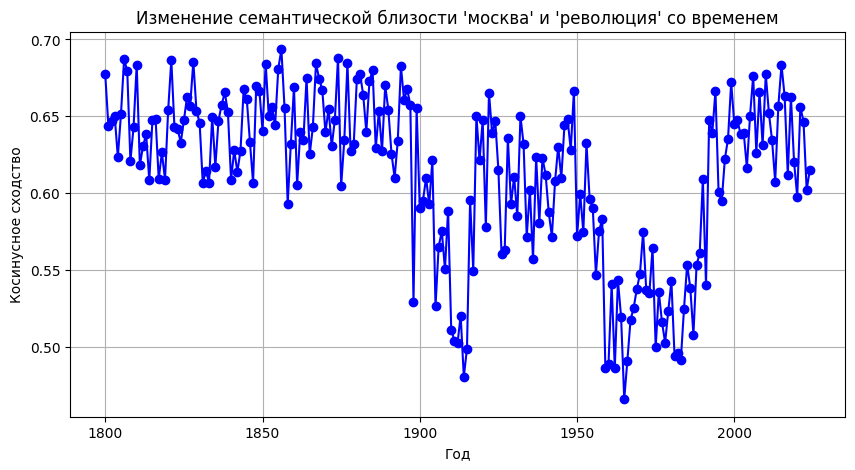

In [236]:
def plot_semantic_shift(model, tokenizer, graph_data, word1, word2):
    """
    Строит график изменения семантической близости двух слов со временем.

    Args:
        model: Твоя модель с временными эмбеддингами.
        tokenizer: BERT-токенизатор.
        graph_data: Социальный граф.
        word1, word2: Два слова, чья близость нужно отследить.
    """
    n_times = model.n_times  # Количество временных слоев
    similarities = []  # Список для значений близости
    years = [1800 + i for i in range(n_times)]  # Преобразуем индексы обратно в годы

    for time_idx in range(n_times):
        emb1 = get_word_embedding(model, word1, tokenizer, graph_data, user_idx=user_idx, time_idx=time_idx)
        emb2 = get_word_embedding(model, word2, tokenizer, graph_data, user_idx=user_idx, time_idx=time_idx)
        similarity = F.cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
        similarities.append(similarity)

    plt.figure(figsize=(10, 5))
    plt.plot(years, similarities, marker='o', linestyle='-', color='b')
    plt.xlabel("Год")
    plt.ylabel("Косинусное сходство")
    plt.title(f"Изменение семантической близости '{word1}' и '{word2}' со временем")
    plt.grid()
    plt.show()

plot_semantic_shift(model, tokenizer, graph_data, "москва", "революция")


# Вывод

Я реализовала создание контекстных временных эмбеддингов для русского языка на основе статьи. В принципе, получилось неплохо, учитывая, что я никогда не работала с node2vec,графы вообще составили отдельную сложность. Но общий результат работы мне понравился

В будущем также я быхотела на основе обученных временных эмбеддингов попробовать реализовать простой классификатор, который бы предсказывал год появления слова